# Curve fitting vs ODE identification

In this notebook we compare two very different approaches of data modeling. The first one consists in simply fitting a predetermined function to the data. And the second one is more inclined towards extracting the dynamics that govern the data.

## Data

This is the data we will be working with:

The trajectory has 300 points with a timestep of 0.033444816053511704


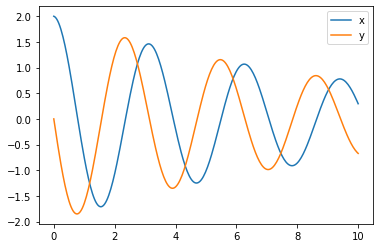

In [25]:
from scipy.optimize import curve_fit
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

data = loadmat('data/py_odes.mat')
t = data['t'][0]
data = data['linear_oscillator']

print(f'The trajectory has {len(data)} points with a timestep of {t[1]}')

for dim in range(data.shape[1]):
    plt.plot(t, data[:, dim], label=['x', 'y', 'z'][dim])
plt.legend()
plt.show()

## Curve-fitting

We will start with the curve fitting approach by using `scipy`'s `curve_fit` method. This method uses a non-linear least squares regression. But first we need to define a cadidate function:

In [61]:
def candidate_function(x, a, b, c, d):
    return d*np.sin(a*x + b)*np.exp(c*x)

And now we can fit the data:

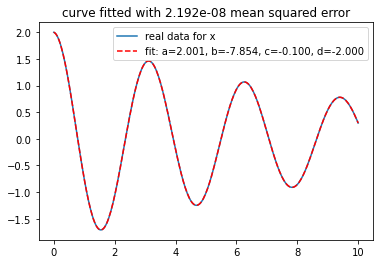

In [69]:
popt, pcov = curve_fit(candidate_function, t, data[:, 0])
mse = ((data[:, 0] - candidate_function(t, *popt))**2).mean()

plt.plot(t, data[:, 0], label='real data for x')
plt.plot(t, candidate_function(t, *popt), 'r--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.legend()
plt.title(f'curve fitted with {mse:{3}.{4}} mean squared error')
plt.show()

This allowed us to fit only the `x` variable but we can do the exact same thing for `y`.

## ODE discovering

Now we will use the dynamic systems approach.

In [70]:
import codebase
from codebase.sparse_regression import *
from codebase.utils import *